<a href="https://colab.research.google.com/github/nahyeon-an/python/blob/main/ML/time-series/Seasonality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install statsmodels==0.13.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 5.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


## Seasonality  
regular, periodic change (반복적인, 주기적인 변화)  
일반적으로 시간, 캘린더를 따름 (day, week, year 에 걸친 반복)  
day, year에 걸친 현실세계의 순환에 따라 발생  
사회의 전통, 컨벤션에 의해 발생  

Seasonality model 2가지를 배워보자  
- indicators : 관찰로 얻는 계절성 (ex. 관측치를 관찰하여 weekly seasonality 를 얻음)  
- fourier feature : 많은 관측치에 대한 season  

## Seasonal plot 과 Seasonal indicators  
trend 를 찾기 위해 moving average 를 사용했던 것처럼, seasonal pattern 을 찾기위해 seasonal plot 을 사용하자  

seasonal plot  
- 시계열의 일부분을 잘라서 보는 것  
- 관찰하고 싶은 season 을 잘라서 봄  

seasonal indicator  
- binary feature  
- seasonal difference 를 나타냄  
- seasonal period 를 카테고리형 피처화할 때 얻게되는 값  
- ex) day 에 one-hot encoding 적용하면 weekly seasonal indicator 를 얻게됨   
- training data 에 추가해 seasonal period 의 평균을 구별해낼 수 있음  

## Fourier Features   
Fourier Feature  
- 더 긴 기간, 더 많은 관측치에 적합한 feature  
- 각 날짜마다 feature 를 만드는 것이 아닌, seasonal curve 의 전체적인 shape 을 만드는 것이 목적  

연간 3번의 아주 긴 movement, 연간 52번의 짧은 weekly movement  
- fourier feature를 이용해 캐치하려는 계절의 frequency  

우리가 만들어낼 모델의 계절과 동일한 frequency를 가지는 주기적인 커브를 훈련데이터에 포함시키려는 아이디어  
우리가 사용하려는 주기적인 커브가 사인과 코사인  

그래서 Fourier feature 라는 건  
- sin, cos 곡선의 쌍 (pair)  
- 잠재적인 frequency 에 대해 가장 긴 것으로 시작하는 쌍  
- 푸리에 쌍은 frequency 빈도를 가짐  

sin, cos 곡선을 훈련셋에 추가한다면, linear regression 알고리즘은 목표값의 계절성 요소를 학습한 가중치를 찾아냄  

## Periodogram 을 이용하여 Fourier Feature 추출하기  
우리의 feature 에 과연 푸리에 쌍을 몇 개 포함시킬 수 있을까?  
periodogram : 시계열에서 frequency 의 강도를 나타냄  
- y = (a \*\* 2 + b \*\* 2) / 2  
- a, b : sin, cos 의 coefficient  
- x 축엔 frequency  

In [ ]:
import numpy as np

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

## Example  

In [ ]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

In [4]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [5]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [6]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [ ]:
tunnel = pd.read_csv('tunnel.csv', parse_dates=['Day'])
tunnel = tunnel.set_index('Day').to_period('D')

In [ ]:
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [ ]:
X = tunnel.copy()
X['day'] = X.index.dayofweek
X['week'] = X.index.week
X['dayofyear'] = X.index.dayofyear
X['year'] = X.index.year

X.head()

,NumVehicles,day,week,dayofyear,year
Day,,,,,
2003-11-01,103536,5,44,305,2003
2003-11-02,92051,6,44,306,2003
2003-11-03,100795,0,45,307,2003
2003-11-04,102352,1,45,308,2003
2003-11-05,106569,2,45,309,2003


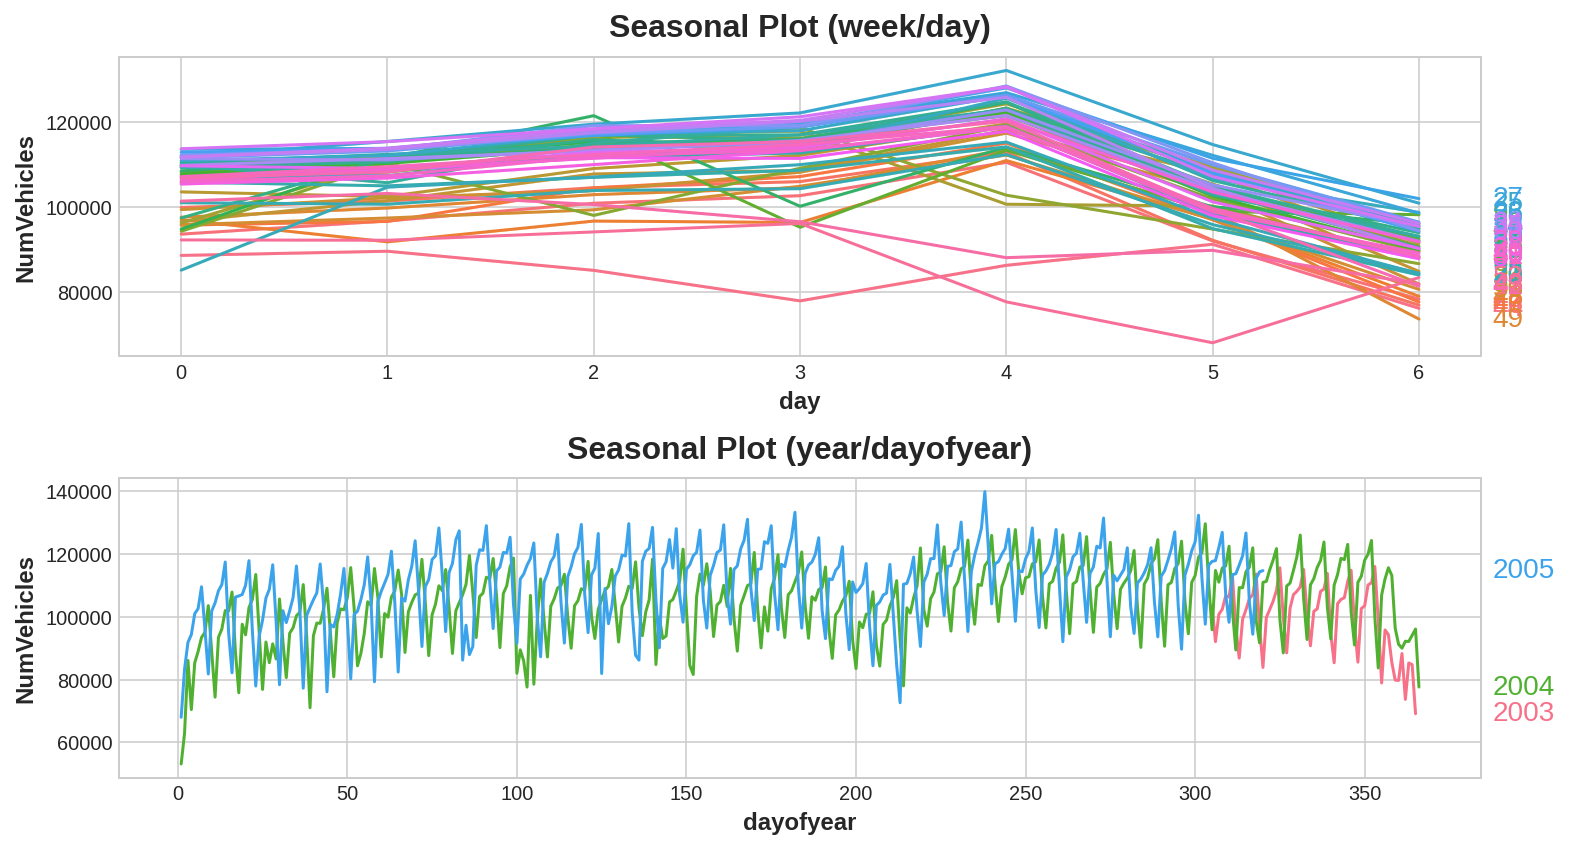

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1)

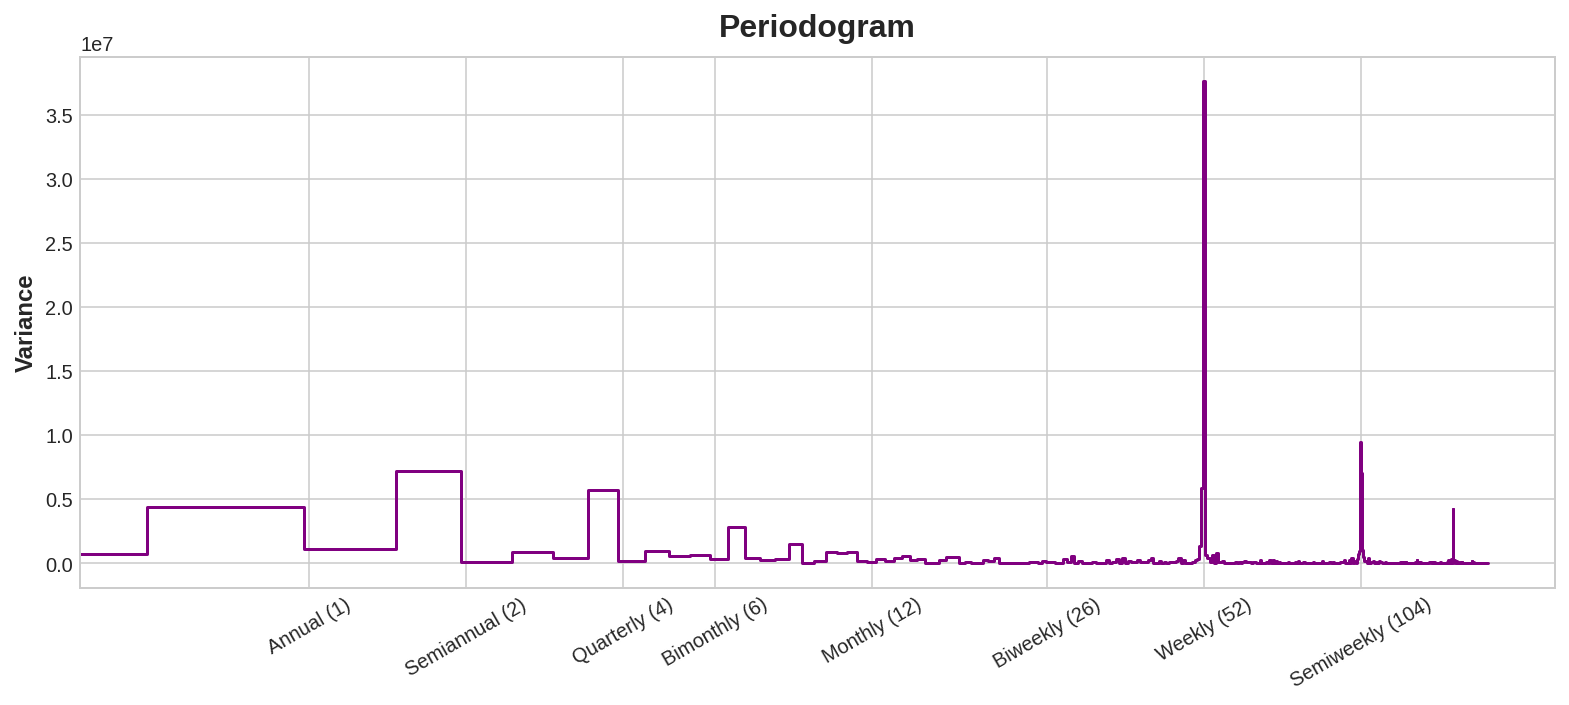

In [ ]:
plot_periodogram(tunnel.NumVehicles)

seasonal feature 를 DeterministicProcess 를 이용해서 만들어보자

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# 10 sin/cos pairs
# A : Annual seasonality
fourier = CalendarFourier(freq="A", order=10)  

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,  # dummy feature for bias, y 교차점
    order=1,  # trend, order == 1은 linear 를 의미
    seasonal=True,  # weekly seasonality, indicator
    additional_terms=[fourier],  # annual seasonality, fourier
    drop=True,  # drop terms to avoid collinearity
)

# tunnel.index 의 날짜에 대한 feature 를 생성
X = dp.in_sample()

X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(6,freq=A-DEC)","cos(6,freq=A-DEC)","sin(7,freq=A-DEC)","cos(7,freq=A-DEC)","sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)"
Day,,,,,,,,,,,,,,,,,,,,,
2003-11-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.867456,0.497513,...,-0.017213,0.999852,-0.875892,0.482508,-0.854322,-0.519744,0.025818,-0.999667,0.880012,-0.474951
2003-11-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.858764,0.512371,...,0.085965,0.996298,-0.811539,0.584298,-0.917584,-0.397543,-0.128748,-0.991677,0.785650,-0.618671
2003-11-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.849817,0.527078,...,0.188227,0.982126,-0.735417,0.677615,-0.963471,-0.267814,-0.280231,-0.959933,0.668064,-0.744104
2003-11-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.840618,0.541628,...,0.288482,0.957485,-0.648630,0.761104,-0.991114,-0.133015,-0.425000,-0.905193,0.530730,-0.847541
2003-11-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.831171,0.556017,...,0.385663,0.922640,-0.552435,0.833556,-0.999991,0.004304,-0.559589,-0.828770,0.377708,-0.925925


feature 가 만들어졌으므로, 모델을 학습하여 예측해보자

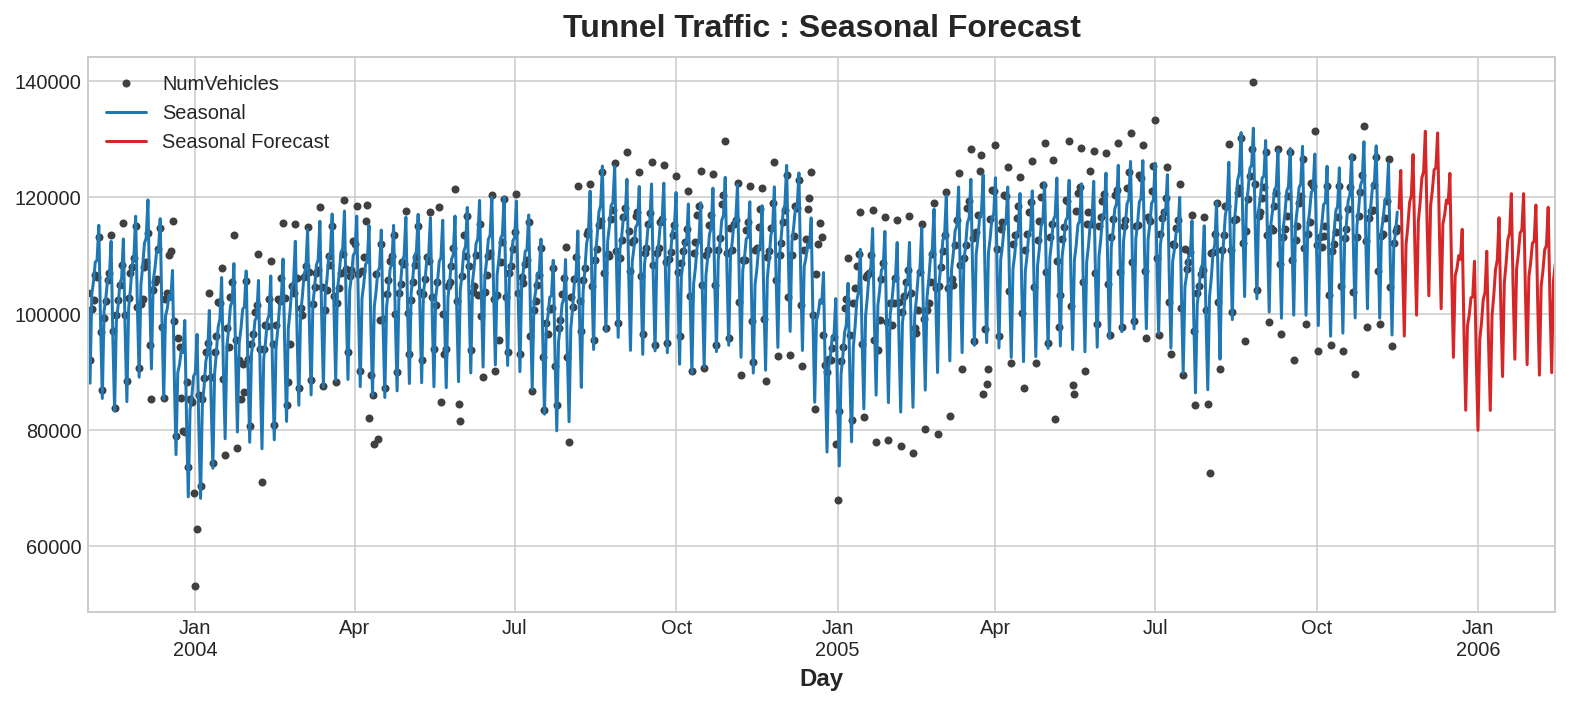

In [ ]:
y = tunnel['NumVehicles']

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)

# 90 일치 feature 생성
X_forecast = dp.out_of_sample(steps=90)
# 생성한 데이터에 대한 예측
y_forecast = pd.Series(model.predict(X_forecast), index=X_forecast.index)

# 시각화
ax = y.plot(color='0.25', style='.', title='Tunnel Traffic : Seasonal Forecast')
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_forecast.plot(ax=ax, label="Seasonal Forecast", color='C3')
ax.legend()

## Exercise

In [3]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [7]:
holidays_events = pd.read_csv(
    'holidays_events.csv',
    dtype = {
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool'
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

In [8]:
holidays_events.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [10]:
store_sales = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales.groupby('date').mean().squeeze().loc['2017']
)

In [11]:
store_sales.head()

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

In [12]:
average_sales.head()

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.608032
2017-01-05    436.375397
Freq: D, Name: sales, dtype: float32

### 0-1. seasonal plot 확인하기

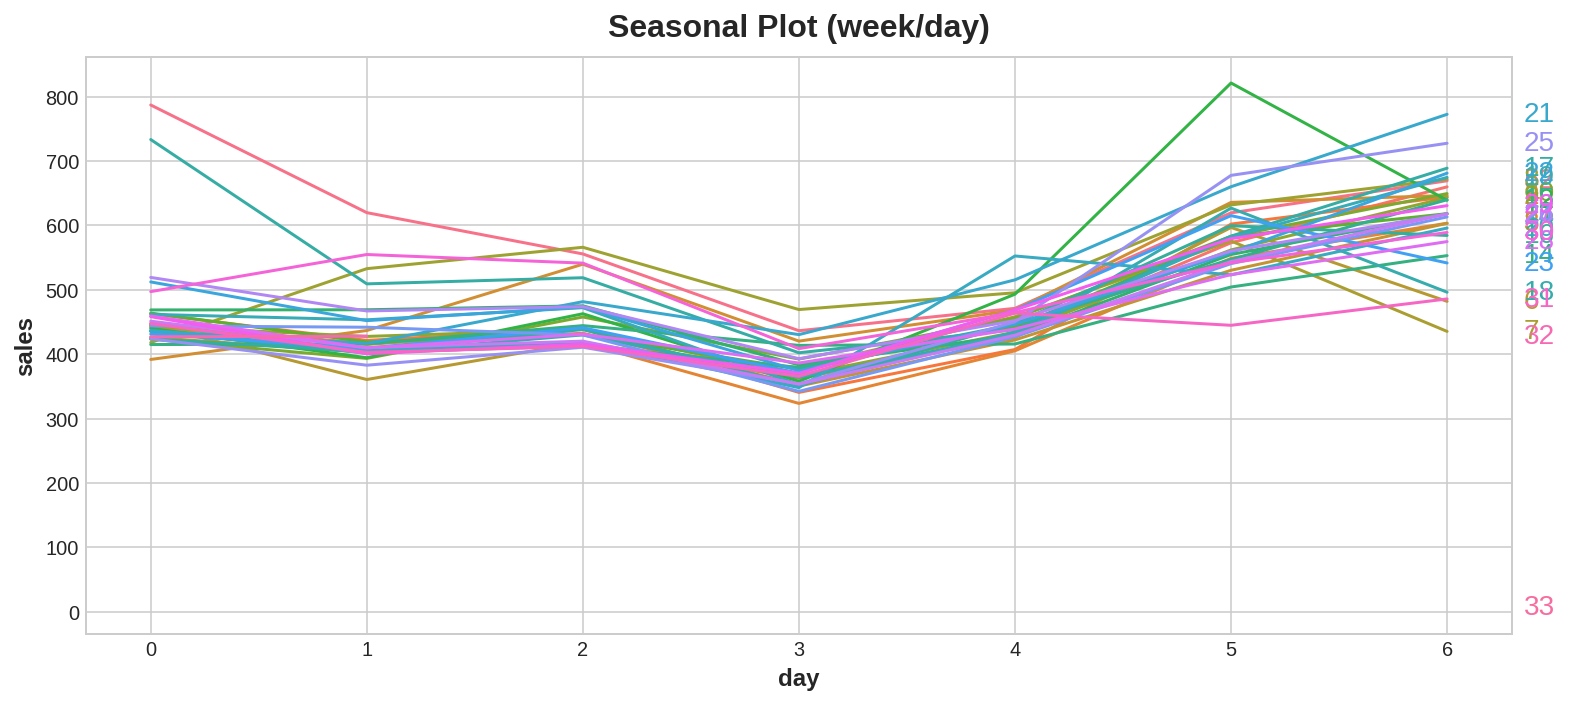

In [13]:
X = average_sales.to_frame()
X['week'] = X.index.week
X['day'] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day')

### 0-2. periodogram 확인하기

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """Entry point for launching an IPython kernel.


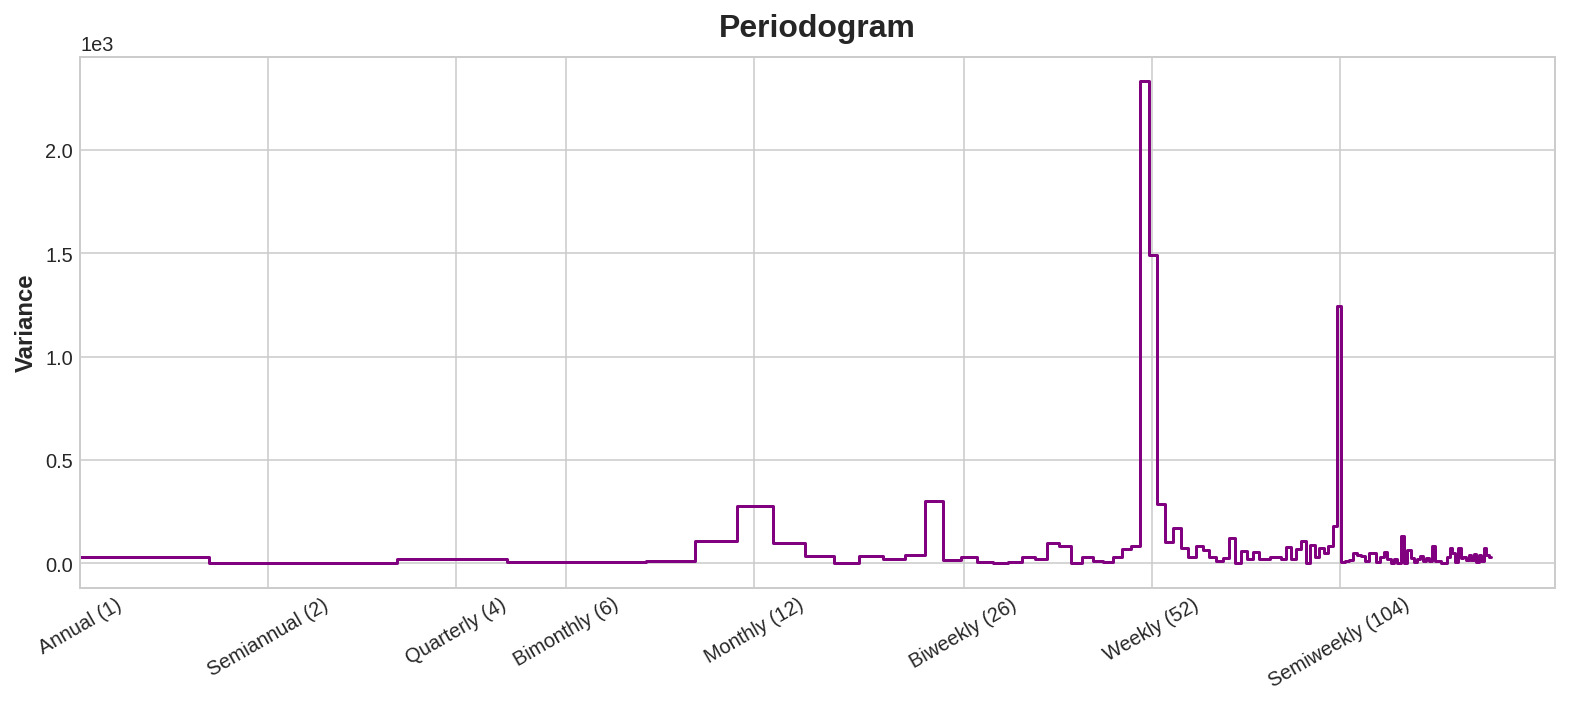

In [14]:
plot_periodogram(average_sales)

### 1. seasonality 결정하기  
위의 그래프에서 어떤 계절성을 확인할 수 있었나?  

seasonal plot 과 periodogram 모두 강한 weekly seasonality 를 보여준다.  
periodogram 에서 monthly, biweekly 요소 또한 존재하는 것으로 나타난다.  
- 이 특성은 데이터셋에서 설명할 수 있는데,  
- Store Sales 데이터셋은 임금이 biweekly 지급된다고 함 (즉, 매달 15일과 마지막날)  
- 따라서 biweekly 와 monthly seasonality 가 여기서 비롯된 것이라 볼 수 있다  

### 2. seasonal feature 를 생성하기  
DeterministicProcess 와 CalendarFourier 를 이용하여 (1) weekly season 을 위한 indicator (2) monthly season 을 위한 order 4 fourier feature 를 생성한다.  

In [15]:
y = average_sales.copy()

# fourier feature
fourier = CalendarFourier(freq='M', order=4)

# weekly indicator
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

In [16]:
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869


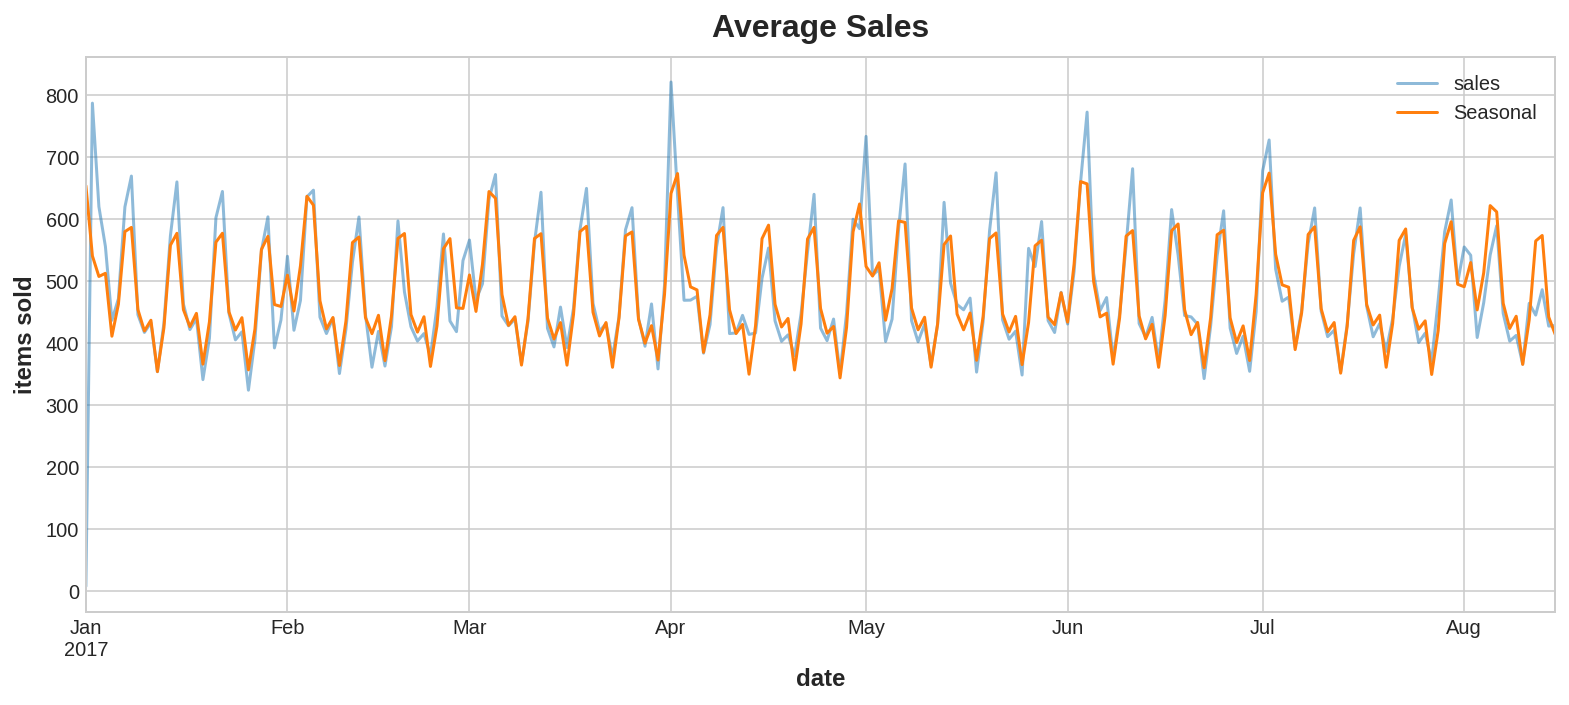

In [17]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend()

deseasonalized series 의 periodogram 을 보자

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  


Text(0.5, 1.0, 'Deseasonalized')

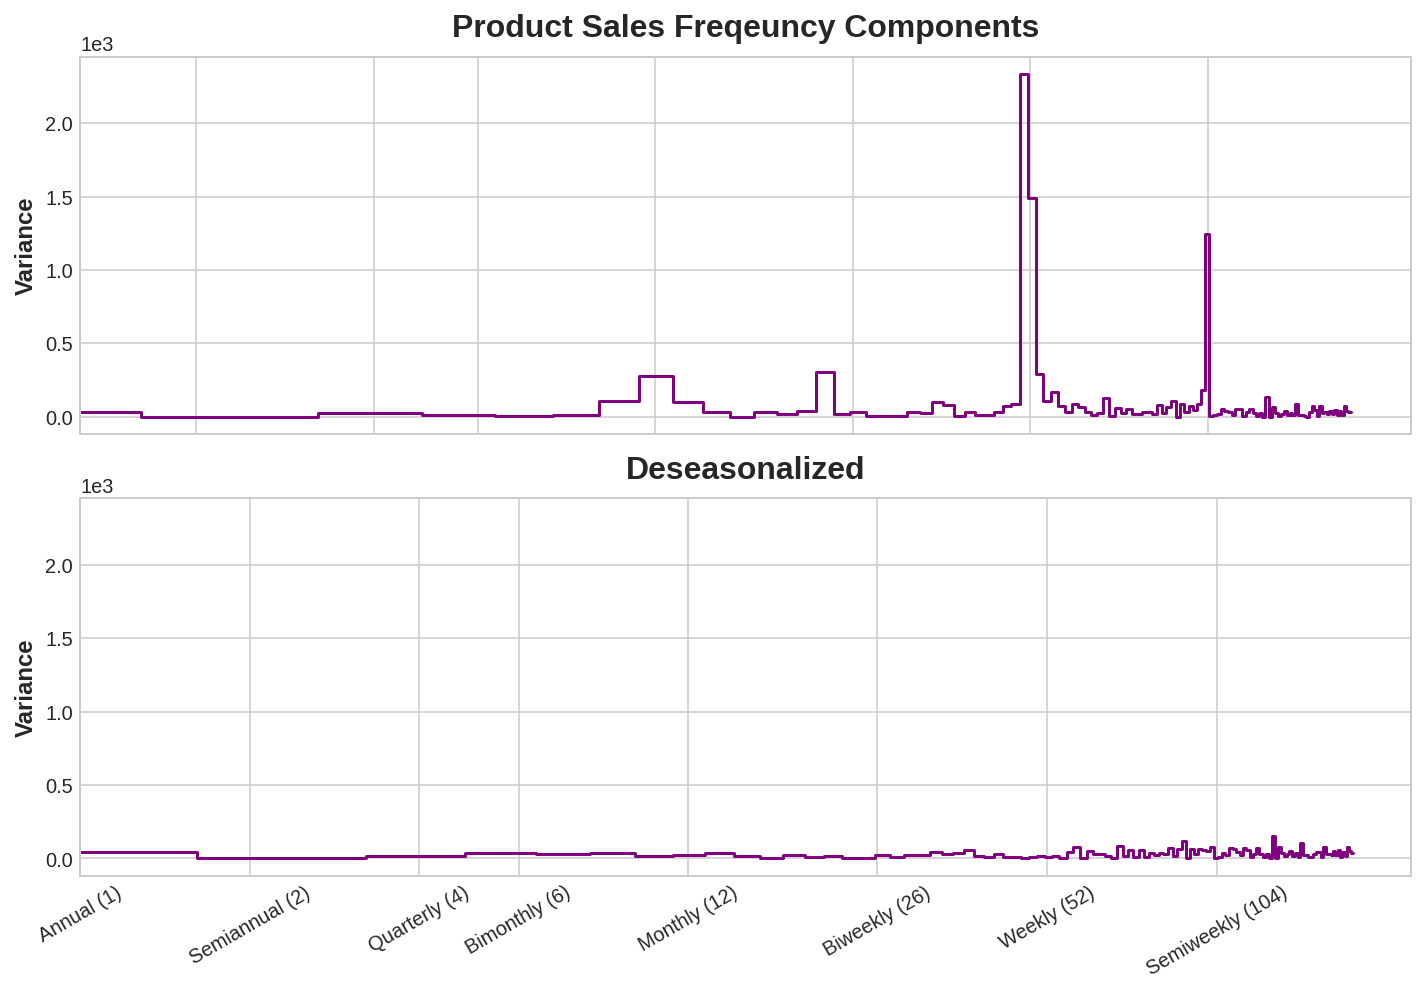

In [18]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Freqeuncy Components")
ax2 = plot_periodogram(y_deseason, ax=ax2)
ax2.set_title("Deseasonalized")

### 3. 남은 seasonality 를 확인하기  
위의 periodogram 을 기반으로, 만든 모델이 seasonality 를 얼마나 잘 잡았는가? periodogram 이 deseasonalized series 플롯과 일치하는가?

deseasonalized series 의 periodogram 은 큰 값들이 부족하다.  
원래 시리즈의 periodogram 과 비교해보면, 만든 모델이 seasonal variation 을 포획할 수 있었음을 알 수 있다.  

In [19]:
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

In [20]:
holidays

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


In [21]:
holidays.index

PeriodIndex(['2017-01-01', '2017-01-02', '2017-02-27', '2017-02-28',
             '2017-04-01', '2017-04-14', '2017-05-01', '2017-05-13',
             '2017-05-14', '2017-05-24', '2017-05-26', '2017-06-25',
             '2017-08-10', '2017-08-11'],
            dtype='period[D]', name='date')

In [22]:
y_deseason[holidays.index]

date
2017-01-01   -646.895992
2017-01-02    246.665065
2017-02-27    -38.372590
2017-02-28     77.236040
2017-04-01    179.831051
2017-04-14    -11.566443
2017-05-01    209.945700
2017-05-13     68.040347
2017-05-14    -76.243078
2017-05-24    -23.882261
2017-05-26    119.470332
2017-06-25     31.341181
2017-08-10      0.346709
2017-08-11     26.696323
Freq: D, dtype: float64

In [23]:
plot_params = {
    'color': '0.75',
    'style': '.-',
    'markeredgecolor': '0.25',
    'markerfacecolor': '0.25',
    'legend': False
}

Text(0.5, 1.0, 'National and Regional Holidays')

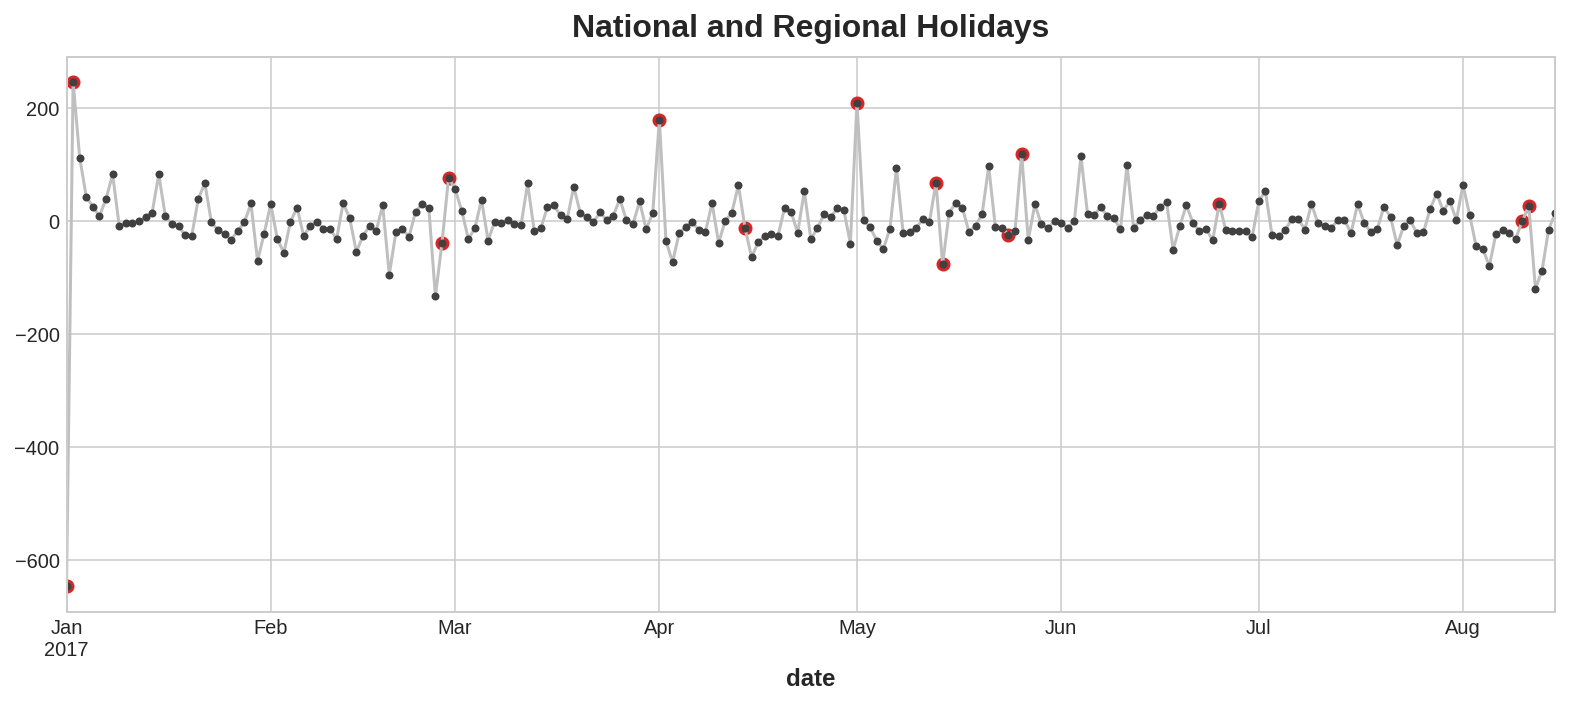

In [24]:
ax = y_deseason.plot(**plot_params)
ax.scatter(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays')

### 4. holiday feature 만들기  
pd.get_dummies 또는 sklearn.preprocessing.OneHotEncoder 를 이용하여 holiday 임을 나타내는 feature 를 만든다.  

In [25]:
X_holidays = pd.get_dummies(holidays)

X2 = X.join(X_holidays, on='date').fillna(0.0)

In [26]:
X_holidays.head()

,description_Batalla de Pichincha,description_Carnaval,description_Dia de la Madre,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,
2017-01-01,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-01-02,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-02-27,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-02-28,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-04-01,0,0,0,0,0,0,0,1,0,0,0,0,0


In [27]:
X2.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


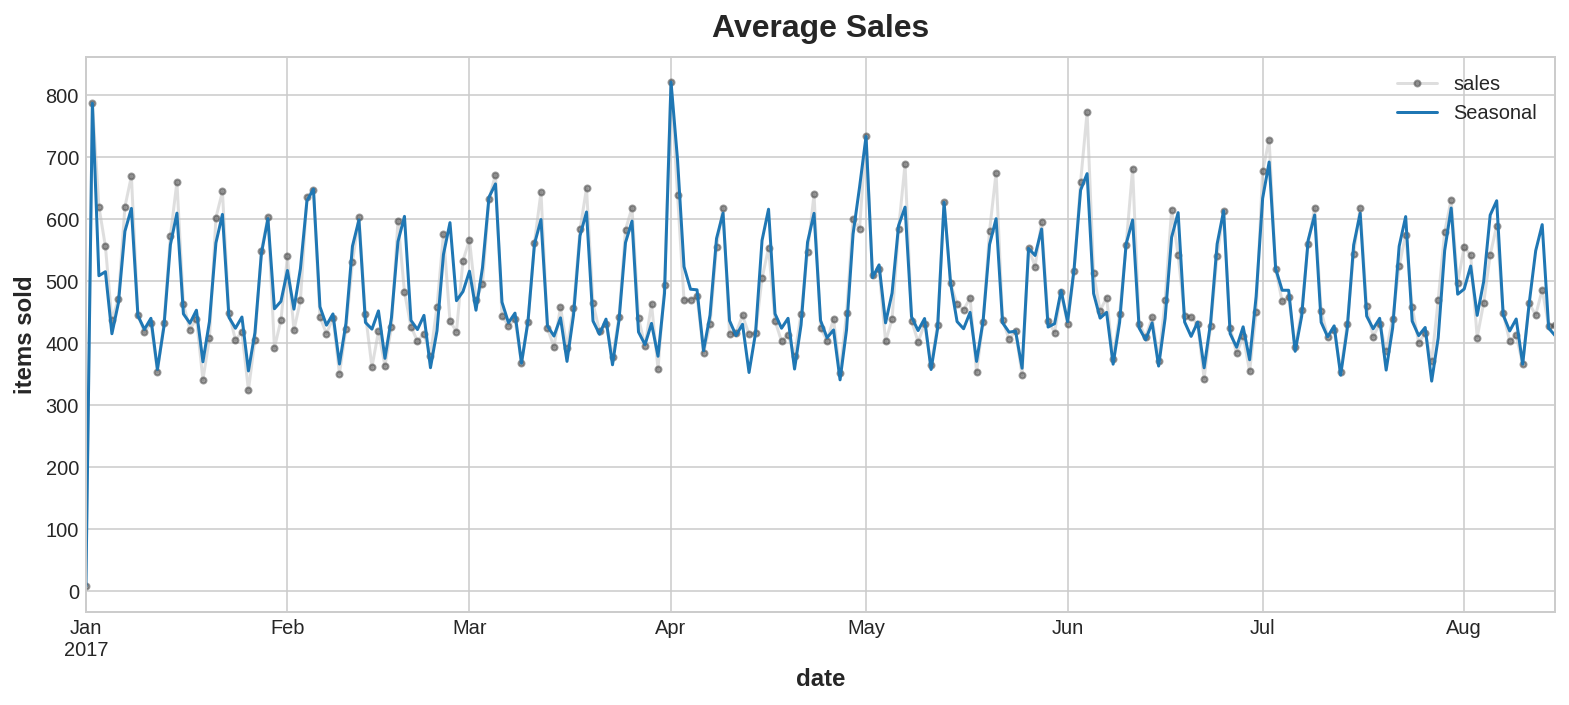

In [28]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(model.predict(X2), index=X2.index)

ax = y.plot(**plot_params, alpha=0.5, title='Average Sales', ylabel='items sold')
ax = y_pred.plot(ax=ax, label='Seasonal')
ax.legend()

### Store Sales

In [29]:
y = store_sales.unstack(['store_nbr', 'family']).loc['2017']
y.head()

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   

                                                     ...            \
store_nbr                                            ...         9   
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-01-01         0.0      0.0     0.0    0.000000  ...       0.0   
2017-01-02         0.0    332.0   376.0   44.980000  ...       5.0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...       2.0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...       3.0   
2017-01-05        40.0    918.0   853.0  137.005997  ...       2.0   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    0.000000           0.0          0.0                     0.0   
2017-01-02  659.570007        1243.0         11.0                    41.0   
2017-01-03  547.364014         876.0          6.0                    15.0   
2017-01-04  395.287994         677.0          6.0                    13.0   
2017-01-05  470.768005         604.0          7.0                    10.0   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01    0.000000       0.000000     0.000000                        0.0   
2017-01-02  843.596008     115.188995  3136.895996                        1.0   
2017-01-03  714.659973     133.039001  3229.558105                        1.0   
2017-01-04  536.830017      75.201004  1491.416992                        7.0   
2017-01-05  414.100006     113.698997  1566.821045                        1.0   

                    
store_nbr           
family     SEAFOOD  
date                
2017-01-01     0.0  
2017-01-02    23.0  
2017-01-03    14.0  
2017-01-04     0.0  
2017-01-05    17.0  

[5 rows x 1782 columns]

In [30]:
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

In [31]:
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",NewYear
date,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,True
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967,False
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649,False
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653,0.651372,-0.758758,False
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758,-0.101168,-0.994869,False


In [32]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [33]:
y_pred.head()

sales                                                      \
store_nbr              1                                                       
family        AUTOMOTIVE BABY CARE        BEAUTY     BEVERAGES         BOOKS   
date                                                                           
2017-01-01  2.775558e-14       0.0  2.131628e-14 -1.364242e-12  1.221245e-15   
2017-01-02  4.158065e+00       0.0  3.693728e+00  2.438526e+03  6.524888e-01   
2017-01-03  4.019103e+00       0.0  3.790063e+00  2.556636e+03  9.822520e-01   
2017-01-04  4.086815e+00       0.0  3.626226e+00  2.722500e+03  1.070364e+00   
2017-01-05  3.927327e+00       0.0  3.109574e+00  2.342817e+03  7.886527e-01   

                                                                    \
store_nbr                                                            
family      BREAD/BAKERY   CELEBRATION      CLEANING         DAIRY   
date                                                                 
2017-01-01  5.968559e-13  4.440892e-15  1.080025e-12  1.080025e-12   
2017-01-02  4.339072e+02  1.278250e+01  7.314578e+02  8.363691e+02   
2017-01-03  4.272647e+02  1.496032e+01  8.624653e+02  8.416939e+02   
2017-01-04  5.002280e+02  1.550328e+01  9.660105e+02  9.806785e+02   
2017-01-05  4.429722e+02  1.901495e+01  7.928288e+02  8.212025e+02   

                          ...                                            \
store_nbr                 ...             9                               
family              DELI  ...     MAGAZINES         MEATS PERSONAL CARE   
date                      ...                                             
2017-01-01  2.557954e-13  ...  3.730349e-14  3.410605e-13 -9.094947e-13   
2017-01-02  1.590167e+02  ...  3.372874e+00  5.205468e+02  8.060135e+02   
2017-01-03  1.538898e+02  ...  2.618076e+00  4.814580e+02  7.538661e+02   
2017-01-04  1.578011e+02  ...  2.058240e+00  4.258345e+02  6.297048e+02   
2017-01-05  1.313682e+02  ...  1.693960e+00  5.888703e+02  5.486101e+02   

                                                                               \
store_nbr                                                                       
family      PET SUPPLIES PLAYERS AND ELECTRONICS       POULTRY PREPARED FOODS   
date                                                                            
2017-01-01  1.065814e-14            2.842171e-14  1.932676e-12  -1.136868e-13   
2017-01-02  9.774855e+00            1.951512e+01  5.960566e+02   1.351610e+02   
2017-01-03  8.359401e+00            1.800615e+01  5.495394e+02   1.304207e+02   
2017-01-04  8.577979e+00            1.546256e+01  4.735746e+02   1.162081e+02   
2017-01-05  5.928875e+00            1.401548e+01  4.097657e+02   1.107939e+02   

                                                                   
store_nbr                                                          
family           PRODUCE SCHOOL AND OFFICE SUPPLIES       SEAFOOD  
date                                                               
2017-01-01  4.547474e-12               5.773160e-14  8.526513e-14  
2017-01-02  2.030560e+03              -6.284309e+00  1.908638e+01  
2017-01-03  2.799504e+03               1.054938e+00  1.826387e+01  
2017-01-04  1.612567e+03              -4.966515e+00  1.547805e+01  
2017-01-05  1.496643e+03              -4.043700e+00  1.342527e+01  

[5 rows x 1782 columns]

Text(0.5, 1.0, 'PRODUCE Sales at Store 1')

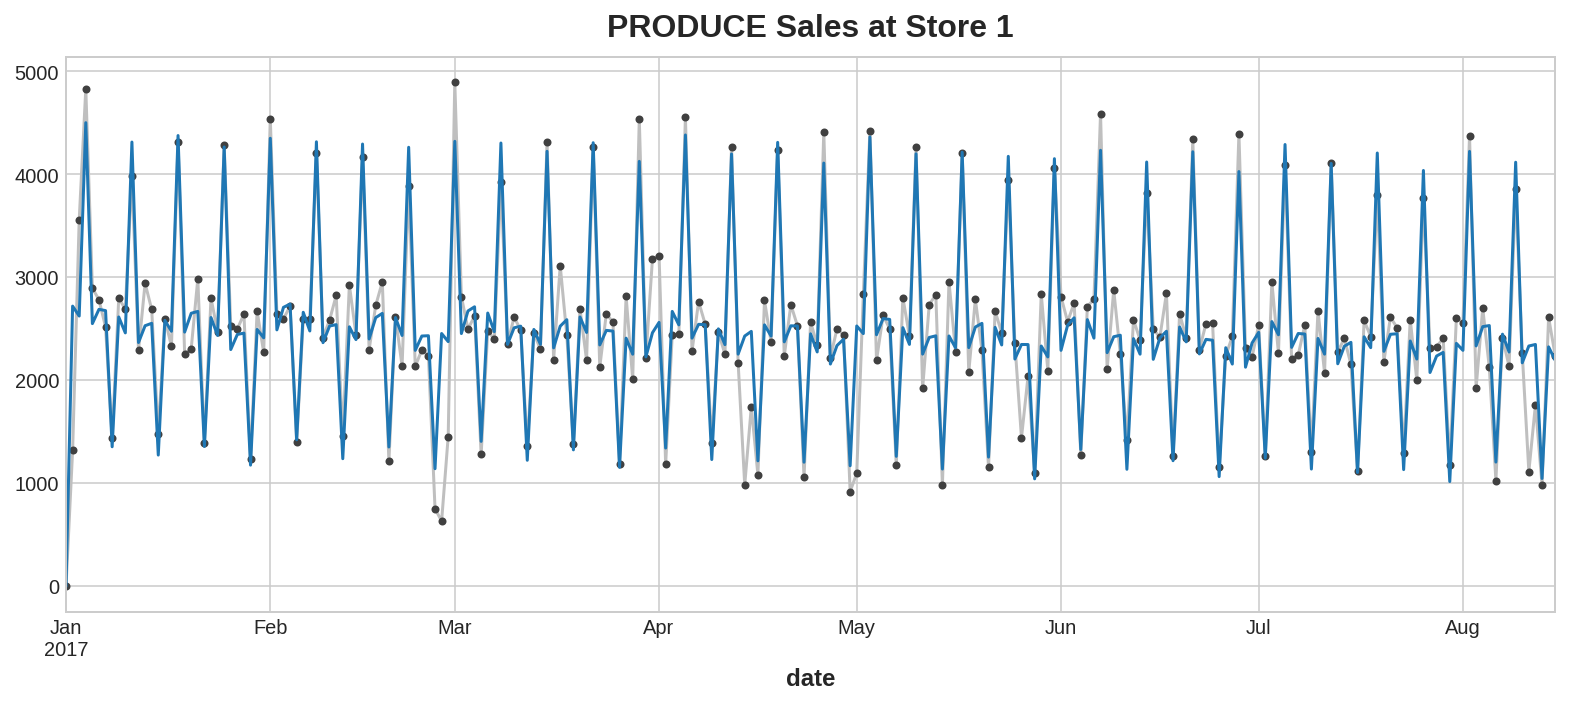

In [35]:
STORE_NBR = '1'
FAMILY = 'PRODUCE'

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}')

In [36]:
df_test = pd.read_csv(
    'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32'
    },
    parse_dates=['date'],
    infer_datetime_format=True
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [37]:
df_test.head()

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0

In [38]:
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)

In [39]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

In [40]:
y_submit.head()

id        sales
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888     4.274030
                     BABY CARE   3000889     0.000000
                     BEAUTY      3000890     3.495530
                     BEVERAGES   3000891  2414.541711
                     BOOKS       3000892     0.438314